In [1]:
import datetime
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import qlat as q

In [2]:
from data import *
import jackknife as jk

# Calculating $\langle E\rangle$

In [3]:
Nt = 100
total_site = [1,1,1,Nt]
lmbd = 0.01
v0 = 3.0
alpha = 0.0
barrier_strength = 100.0
M = "1.0"
L = "0.0"
t_full = "5"
t_FV = "*"
m_particle = 1.0
dt = 0.2
#
version = "1-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_75_2024-01-11_1-1.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_2024-01-11_1-1.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_2024-01-11_1-1.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_70_2024-01-11_1-1.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_85_2024-01-11_1-1.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_2024-01-11_1-1.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_80_2024-01-11_1-1.bin


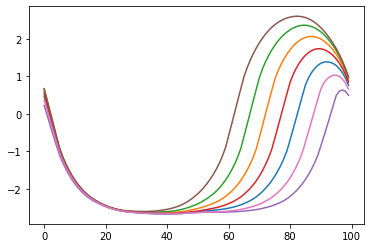

In [4]:
measurements.plot_mean_path()
plt.show()

[0.38320387088209507, 0.19998760952050332, 0.07152787017714676, -0.018307282199245094, -0.08058611319964533]
[0.34106579050817015, 0.17053898362684042, 0.05087879121495884, -0.032676524498533574, -0.09046364573722997]


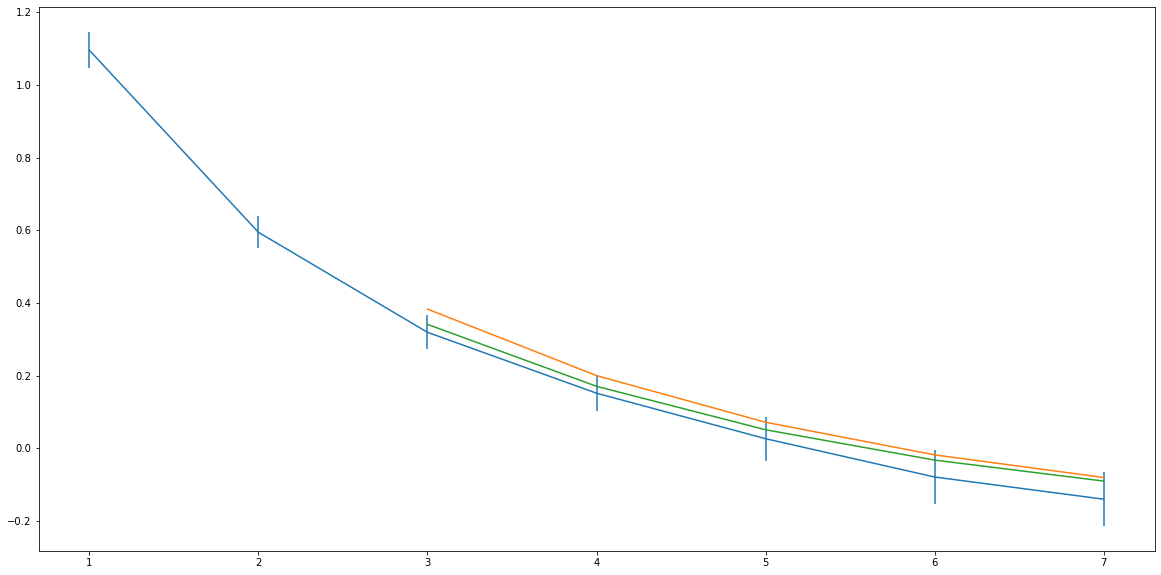

In [13]:
measurements.plot_Ebar_E_FV(1)
#measurements.plot_Ebar_E_FV(2)
#measurements.plot_Ebar_E_FV(-2)
#measurements2.plot_Ebar_E_FV(-2)
plot_E_tdse()
plot_E_tdse(2)
#plt.xlim(8,42)
#plt.ylim(-0.7,0.7)

fig = plt.gcf()
fig.set_size_inches(20, 10)

[0.42803769 0.35841281 0.29972513 0.24955727]


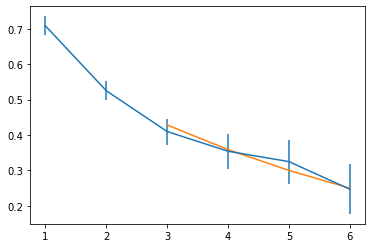

In [14]:
measurements.plot_Ebar_slope()
plot_slope_tdse()

[0.38320387088209507, 0.19998760952050332, 0.07152787017714676, -0.018307282199245094, -0.08058611319964533]
[0.42803769 0.35841281 0.29972513 0.24955727]


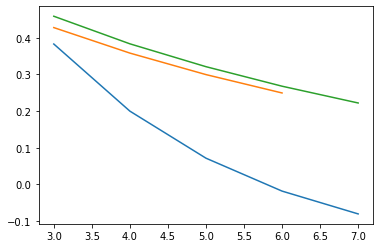

In [11]:
t_full_tdse = 1.0
t_total_tdse = 20.0
t_FV_tdse = [[7.5, 7.6, 6.4], 
             [7.0, 7.1, 6.9], 
             [6.5, 6.6, 6.4], 
             [6.0, 6.1, 5.9], 
             [5.5, 5.6, 5.4]]
t_FV_tdse = np.multiply(t_FV_tdse,2)
t_TV_tdse = [[1.5, 1.4, 1.6], 
             [2.0, 1.9, 2.1], 
             [2.5, 2.4, 2.6], 
             [3.0, 2.9, 3.1], 
             [3.5, 3.4, 3.6]]
t_TV_tdse = np.multiply(t_TV_tdse,2)
corr_tdse = [[8.248663373196439e-08, 8.905703783595409e-08, 7.704757642858247e-08],
             [6.309382431172544e-08, 6.566856939543131e-08, 6.097811910246092e-08],
             [5.599952880841047e-08, 5.680639177237058e-08, 5.543258059759522e-08],
             [5.51639432842981e-08, 5.4962332229197884e-08, 5.5525637075399806e-08],
             [5.8430364009058354e-08, 5.7496177293354066e-08, 5.9497150195223996e-08]]
corr0 = 0.0002828628961749551 # Correlation function when only H_FV is used

def plot_E_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][j]/corr_tdse[i][0])/(t_TV_tdse[i][0]-t_TV_tdse[i][j]))
    plt.plot(E_t_TV_tdse, E_tdse)
    print(E_tdse)

def plot_slope_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][j]/corr_tdse[i][0])/(t_TV_tdse[i][0]-t_TV_tdse[i][j]))
    plt.plot(E_t_TV_tdse[:-1], (-np.subtract(E_tdse[1:], E_tdse[:-1]))**0.5/np.subtract(E_t_TV_tdse[1:],E_t_TV_tdse[:-1]))
    print((-np.subtract(E_tdse[1:], E_tdse[:-1]))**0.5/np.subtract(E_t_TV_tdse[1:],E_t_TV_tdse[:-1]))

def plot_delta_E_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][1]*corr_tdse[i][2]/corr_tdse[i][0]**2)**0.5/(t_TV_tdse[i][0]-t_TV_tdse[i][1]))
    plt.plot(E_t_TV_tdse, E_tdse)

plot_E_tdse()
plot_slope_tdse()
plot_delta_E_tdse()

In [15]:
R = 5.599952880841047e-08/corr0
dE = 0.29972513
Ebar_m_E_FV = 0.07152787017714676

R*(2*np.pi)**0.5/dE * np.exp(-(Ebar_m_E_FV)**2/2/dE**2)/(5*0.2)**2

0.0016091937249886627

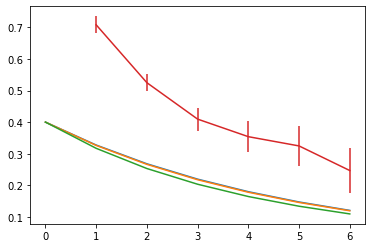

In [9]:
m_particle = 1.0
E0 = 0.4
Gamma = 0.0015
def E_dist(E,t):
    return 1/((E-E0)**2+Gamma**2/4.0)*np.exp(-E*t)

dE = 0.0001
Es=np.arange(0,2*E0,dE)
#plt.plot(Es, E_dist(Es,4.0))

def get_delta_E(t):
    return (np.sum(E_dist(Es,t)*Es**2)*dE)**0.5

def plot_delta_Es():
    dEs=[]
    for t in np.arange(0,7,1):
        dEs.append(get_delta_E(t))
    plt.plot(np.divide(dEs,2.5*dEs[0]))

plot_delta_Es()
Gamma = 0.015
plot_delta_Es()
Gamma = 0.15
plot_delta_Es()
measurements.plot_Ebar_slope()
#plot_half_slope_tdse()

[0.1427265665569765, 0.0920444510400993]


/home/joshua/Joshua/School/Research/Qlattice/applications/false-vacuum-decay/data.py:195: RuntimeWarning: invalid value encountered in sqrt
  bdiv = np.log(np.divide(blocks_FVa2,blocks_TVa2)/np.divide(blocks_FVa,blocks_TVa)**2.0)**0.5/(dt*delta_t2)
/home/joshua/qlat-build/nov_2023/Python-venv/lib64/python3.10/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/joshua/qlat-build/nov_2023/Python-venv/lib64/python3.10/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


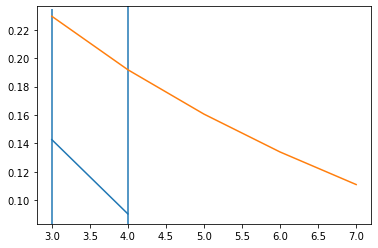

In [8]:
measurements.block_size = 200
measurements.cutoff = 2000

sfs = measurements.get_sfs_list(list(measurements.delta_actions_t_TV), ["M", "L"], [1.0, 0.0])
print(measurements.get_delta_E(sfs[0]))

measurements.plot_delta_E()

plot_delta_E_tdse()
#a = measurements.get_delta_E(sf)
#plt.errorbar([3], [-a[0]], yerr=[a[1]])

[0.31928225666093996, 0.0466713256630312]
0.319282256660941


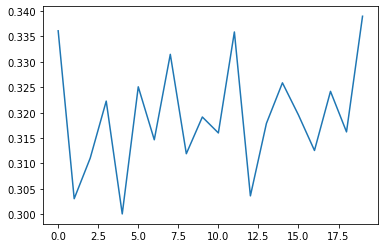

In [50]:
measurements.block_size = 2000
measurements.cutoff=10000

t_TV = measurements.get_t_TV(sf)
t_FV = int(measurements.get_param(sf,"tFV"))
dt = float(measurements.get_param(sf, "dt"))

blocks_TV = jk.get_jackknife_blocks(np.exp(measurements.delta_actions_t_TV[sf][f"{t_TV+1}"][measurements.cutoff:]), measurements.block_size)
blocks_FV = jk.get_jackknife_blocks(np.exp(measurements.delta_actions_t_FV[sf][f"{t_FV+1}"][measurements.cutoff:]), measurements.block_size)
bdiv = np.log(np.divide(blocks_FV,blocks_TV))/(dt*1)

#plt.plot(np.exp(measurements.delta_actions_t_FV[sf][f"{t_FV+1}"][measurements.cutoff:measurements.cutoff+100]))
plt.plot(bdiv[:])
print(jk.get_errors_from_blocks(np.mean(bdiv), bdiv))
print(np.mean(bdiv))

# Changing M and L

In [3]:
Nt = 100
total_site = [1,1,1,Nt]
lmbd = 0.01
v0 = 3.0
alpha = 0.0
barrier_strength = 100.0
M = "*"
L = "*"
t_full = 5
t_FV = 75
m_particle = 1.0
dt = 0.2
#
version = "0-7"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 5000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.032_tfull_5_tFV_75_2023-12-15_0-7.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_75_2023-12-15_0-7.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.032_L_1.0_tfull_5_tFV_75_2023-12-15_0-7.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.004_L_1.0_tfull_5_tFV_75_2023-12-15_0-7.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.128_L_1.0_tfull_5_tFV_75_2023-12-15_0-7.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.128_tfull_5_tFV_75_2023-12-15_0-7.bin
Loading output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_75_2023-12-15_0-7.bin


In [4]:
#for M in np.arange(0.0, 1.0, 0.001):
#    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{round(M,5)}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#    measurements.load(f"output_data/measurements_{fileid}.bin")

In [5]:
#M = 1.0
#for L in np.arange(0.0, 1.0, 0.001):
#    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{round(L,5)}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#    measurements.load(f"output_data/measurements_{fileid}.bin")

output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_75_2023-12-15_0-7.bin
No previous factor found for M=0.0
[0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
[0.038845211387573776, 0.007397689733758912, 0.0012145254207340949, 0.00017200647280426698, 1.6992050108102766e-05, 7.136402936382012e-07, 5.05215825093752e-09, 8.635130524283471e-13, 3.335640490532055e-20]
[0.0023444186506263232, 0.0008441082507224869, 0.00020914950409037965, 3.8464298998678934e-05, 5.288820581770756e-06, 3.635868876901121e-07, 4.469731756616872e-09, 8.808652748211195e-13, 3.415136748604333e-20]
output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.004_L_1.0_tfull_5_tFV_75_2023-12-15_0-7.bin
[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
[0.0012251785229559177, 0.0001784881756315612, 2.1689568610254725e-05, 2.1876573332019775e-06, 2.366972827752145e-07, 3.646318863534467e-08, 3.0919626568480494e-09, 3.459120

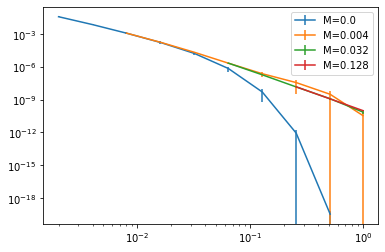

In [6]:
measurements.plot_expS_vs_M()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_80_2023-12-11_0-6.bin
No previous factor found for L=0.0
output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.032_tfull_5_tFV_80_2023-12-11_0-6.bin
output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.128_tfull_5_tFV_80_2023-12-11_0-6.bin


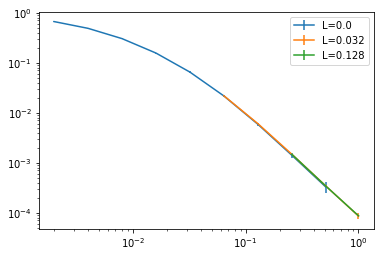

In [7]:
measurements.plot_delta_actions_vs_L()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [5]:
Ms = [0.0, 0.004, 0.032, 0.128, 1.0]
Ls = [0.0, 0.032, 0.128, 1.0]
da_list = measurements.get_M_L_list(Ms, Ls)
ratio=measurements.calc_ratio(da_list, len(Ms)-1)
print(ratio)

0.0003419883600570978


In [7]:
blocks = jk.get_super_jackknife_blocks(da_list, 1000, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(ratio, blocks)

[0.0003407613147241979, 5.7501925042265136e-05]

In [58]:
# v0 = 3.0, t_full = 5, t_FV = 75, t_TV = 15
rFVTV = 1.3361108992708735e-07
rFVTV17 = 1.0676114164860719e-07
rFVTV16 = 1.1873480532715151e-07
rFVTV14 = 1.523168101048299e-07
rFVFV = 0.00028455796788384393
rFVTV/rFVFV, #np.log(rFVTV/rFVTV17)/0.2/2

(0.00046953909223032954,)

In [51]:
# v0 = 3.3
rFVTV = 7.2222477872264384e-09
rFVFV = 0.00012520877325654828
rFVTV/rFVFV

5.7681643221823696e-05

# Changing t_full

In [322]:
Nt = 200
total_site = [1,1,1,Nt]
lmbd = 0.01
v0 = 5.0
alpha = 0.0
barrier_strength = 1.0
M = 1.0
L = 0.0
t_full = 0
t_FV = 150
m_particle = 1.0
dt = 0.2
#
version = "0-5"
date = "*" #datetime.datetime.now().date()


fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
action = q.QMAction(lmbd, v0, alpha, barrier_strength, M, L, t_full, t_FV, m_particle, dt)

cutoff = 10000
block_size = 200

measurements = Data(Nt, cutoff, block_size, action)

In [323]:
for t_full in range(0, 31):
    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV-t_full*2}_{date}_{version}"
    measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x200_lmbd_0.01_v0_5.0_alpha_0.0_m_1.0_dt_0.2_bar_1.0_M_1.0_L_0.0_tfull_0_tFV_150_2023-12-06_0-5.bin


In [324]:
Nt = 400
total_site = [1,1,1,Nt]
t_FV = 300
dt = 0.1

for t_full in range(0, 31):
    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV-t_full*2}_{date}_{version}"
    measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x400_lmbd_0.01_v0_5.0_alpha_0.0_m_1.0_dt_0.1_bar_1.0_M_1.0_L_0.0_tfull_0_tFV_300_2023-12-06_0-5.bin


In [325]:
Nt = 800
total_site = [1,1,1,Nt]
t_FV = 600
dt = 0.05

for t_full in range(0, 31):
    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV-t_full*2}_{date}_{version}"
    measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x800_lmbd_0.01_v0_5.0_alpha_0.0_m_1.0_dt_0.05_bar_1.0_M_1.0_L_0.0_tfull_0_tFV_600_2023-12-06_0-5.bin


In [132]:
#measurements.plot_paths()
#plt.show()
print(np.mean(measurements.accept_rates[list(measurements.accept_rates)[0]]))

8.055670735768934e-05


In [ ]:
measurements.plot_mean_path()
plt.show()

NameError: name 'cutoff' is not defined

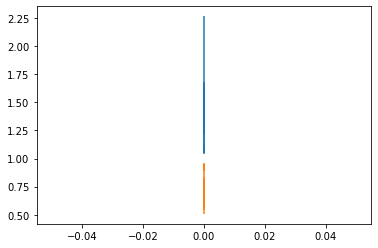

In [274]:
measurements.plot_action_pa()
measurements.plot_action_ma()
plt.show()

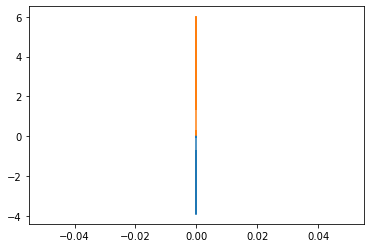

In [275]:
measurements.plot_Ebar_pa()
measurements.plot_Ebar_ma()
plt.show()

output_data/measurements_1x200_lmbd_0.01_v0_5.0_alpha_0.0_m_1.0_dt_0.2_bar_1.0_M_1.0_L_0.0_tfull_0_tFV_150_2023-12-06_0-5.bin
[1.55219209 2.39780146 3.78537059 5.29579093 6.45277607 6.94842493
 7.07356136]
[0.02246161 0.11530228 0.44288682 0.85239219 1.23841942 1.421805
 1.46054198]
output_data/measurements_1x400_lmbd_0.01_v0_5.0_alpha_0.0_m_1.0_dt_0.1_bar_1.0_M_1.0_L_0.0_tfull_0_tFV_300_2023-12-06_0-5.bin
[1.26386363 1.57808677 1.94549907 2.3739458  2.81682988 3.28662911
 3.73298888 4.13259271 4.4382196  4.64953306 4.79700406 4.91098769
 5.00521746 5.06164991 5.11063503]
[0.01046875 0.02769587 0.0545185  0.09603982 0.15214415 0.23153388
 0.32633117 0.42327415 0.49743506 0.53601303 0.56038615 0.57820916
 0.59526308 0.60655525 0.61824634]
output_data/measurements_1x800_lmbd_0.01_v0_5.0_alpha_0.0_m_1.0_dt_0.05_bar_1.0_M_1.0_L_0.0_tfull_0_tFV_600_2023-12-06_0-5.bin
[1.13425836 1.28219396 1.44588771 1.62958349 1.83481106 2.05959544
 2.30738084 2.57979641 2.86630932 3.16955854 3.48935075 3.

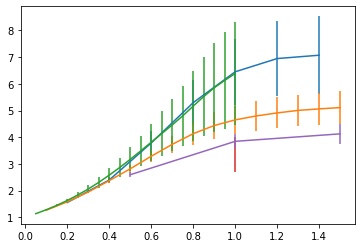

In [286]:
measurements.plot_delta_actions(1.5)

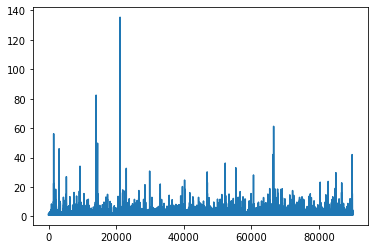

1.5521920850111117

In [374]:
obs = np.exp(measurements.delta_actions[list(measurements.delta_actions)[0]]["1"][measurements.cutoff:])
plt.plot(obs)
plt.show()
np.mean(obs)

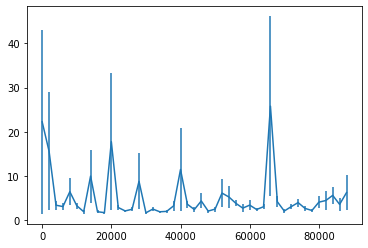

In [368]:
measurements.block_size = 200
measurements.plot_change_over_mdtime(obs, 2000)
plt.show()

In [120]:
# Results from TDSE (lmbd = 0.01, v0 = 3.0, t_FV = 30-2*t_full, t_TV = 10)
r0 = 1.496850959872808e-10
r1 = 1.8485630097863152e-10
r3 = 2.7265213845252313e-10
r5 = 3.8890096730631984e-10
r6 = 4.6004968931214157e-10
r10 = 8.608388298349765e-10
r11 = 9.981885338288639e-10
r20 = 3.4701396396449028e-09
r21 = 3.961703585161057e-09

r1/r0, r3/r0, r6/r5, r11/r10, r21/r20

(1.2349679823456794,
 1.8215049177353717,
 1.1829481744378925,
 1.1595533324399614,
 1.1416553789075923)

In [238]:
# Results from TDSE (lmbd = 0.01, v0 = 5.0, t_FV = 30-2*t_full, t_TV = 10)
r0 = 1.6755914129618976e-30
r1 = 2.5878892951144723e-30
r2 = 3.828712923428258e-30
r3 = 5.488734441290352e-30
r5 = 1.0557859408250743e-29

r1/r0, r2/r0, r3/r0, r5/r0

(1.5444632116727852, 2.28499196988623, 3.275699791029643, 6.300974883601188)

In [18]:
# Results from TDSE (lmbd = 0.01, v0 = 3.0, t_FV = 40-2*t_full, t_TV = 40)
r0 = 2.1840170364864471e-13
r1 = 2.8385922934101394e-13
r2 = 3.636351067839724e-13
r3 = 4.60641571180424e-13
r5 = 7.160697476827908e-13
r6 = 8.826371143493919e-13
r10 = 1.923078742667552e-12
r12 = 2.765824663312932e-12
r13 = 3.3036205900290295e-12
r25 = 2.3505464443480177e-11
r26 = 2.7450981954454293e-11
r27 = 3.20329098801283e-11
r28 = 3.7352073666105134e-11

# Results from TDSE (lmbd = 0.01, v0 = 3.0, t_FV = 60-2*t_full, t_TV = 20)
r0 = 2.852267060920678e-16
r1 = 3.6580414886066613e-16
r5 = 8.775380943430253e-16
r6 = 1.0687467683764056e-15
r25 = 2.326056531512908e-14
r26 = 2.691187027969802e-14
r28 = 3.595290288587937e-14

1.2825031494161312

In [13]:
# Results from TDSE for v0 = 5.0 (lmbd = 0.01, v0 = 3.0, t_FV = 40-2*t_full, t_TV = 40)
r0 = 1.2610924399522462e-34
r1 = 2.0353224811104994e-34
# Results from TDSE for v0 = 5.0  (lmbd = 0.01, v0 = 5.0, t_FV = 60-2*t_full, t_TV = 20)
r5 = 3.703788377624818e-39

1.6139359944046376